In [1]:
import xarray as xr
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score as f1
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import auc
import skimage.io as io
import pandas as pd
import scipy.stats as stats
import scipy as sp
from scipy import ndimage
import os
import dataframe_image as dfi
sns.set()

In [2]:
all_data = xr.load_dataarray(r'C:\Users\leeatgen.WISMAIN\Desktop\Vova\all_data.nc')

In [3]:
path_main = r'C:\Users\leeatgen.WISMAIN\Desktop\Vova\Leeat Keren\8_25epxeriments\outputs\21_05_01'
result_p = os.path.join(path_main,'results')

In [4]:
hat_dat = torch.load(os.path.join(path_main,'iter164500_0.23.pt'),map_location=torch.device('cpu'))
hat_dat = hat_dat.detach().numpy().squeeze()

In [5]:
def print_scores(scores, channels, ch_range):
    new_metric = np.zeros([1,ch_range])
    for i, chname in enumerate(channels):
        new_metric[0,i] = scores[0][0][i]/(scores[1][0][i]*100)
        print('For ch {}_{}'.format(i, chname))
        print('The f1 score is {:.2f} rmse is {:.6f} new metric {:.2f} '.format(scores[0][0][i], scores[1][0][i], new_metric[0,i]))

In [6]:
def get_scores(p_true, p_hat, point_name,channels):
    
    ch_range = len(channels)
    f1scores = np.zeros([1,ch_range])
    rmsescores = np.zeros([1,ch_range])
    falsepositive = np.zeros([1,ch_range])
    falsenegative = np.zeros([1,ch_range])

    for i,chname in enumerate(channels):

        true_data = p_true.sel(fovs=[point_name], channels = chname)
        true_data = true_data.values.squeeze().flatten()
        
        hat_data = p_hat[i,:,:].squeeze().flatten()
        hat_data = np.rint(hat_data)
        hat_data = hat_data.clip(min=0)
        
        binary_true = 1 * (true_data > 0)
        binary_hat = 1 *(hat_data > 0)
        
        falsepositive[0,i] = sum((binary_hat - binary_true) == 1) / len(binary_hat)
        falsenegative[0,i] = sum((binary_hat - binary_true) == -1) / len(binary_hat)
        f1scores[0,i] = f1(binary_true,binary_hat)
        rmsescores[0,i] = mse(true_data, hat_data, squared = False)/np.linalg.norm(true_data, ord=None, axis=None, keepdims=False) 
        
    return(f1scores, rmsescores, falsepositive, falsenegative)
        
        

In [7]:
def save_pics(data, prefix, channels, path):
     
    for i,chname in enumerate(channels):
        pic_data = data[i,:,:].squeeze().flatten()
        pic_data = np.rint(pic_data)
        pic_data = pic_data.clip(min=0)
        pic_name = '{}_00{}_{}.tif'.format(prefix,i,chname)
        io.imsave(os.path.join(path,pic_name), pic_data.reshape((2048,2048)), check_contrast=False)

In [8]:
def combine_everyting(p_true, p_dat, channels, path, pics=False, point_name='Point5'):
    
    if pics:
        pic_path = os.path.join(path, 'pictures')
        save_pics(p_dat, 'hat', channels, pic_path)
        
    scores = get_scores(p_true, p_dat, point_name, channels)
    scores_df = pd.DataFrame({'F1':scores[0][0],'RMSE':scores[1][0],'FalsePos':scores[2][0],'FalseNeg':scores[3][0]},index = channels)
    scores_df.to_csv(os.path.join(path, 'scores.csv'), index = True)
    
    f = plt.figure()
    f.set_figheight(20)
    f.set_figwidth(30)
    ax = f.add_subplot(311)
    ax2 = f.add_subplot(312)
    ax3 = f.add_subplot(313)

    scores_df.loc[:,['FalsePos','FalseNeg']].plot.box(ax=ax3)

    ax.bar(channels,scores[0][0])

    ax2.scatter(range(1,26),sorted(list(scores[0][0])))
    ax2.set_xlabel('Channels in f1 ascending order')
    ax2.set_ylabel('F1 score')
    ys = scores[0][0]
    ax2.set_title('computed AUC using sklearn.metrics.auc: {}'.format(auc(range(1,26),ys)))

    f.savefig(os.path.join(path,'plots.pdf'))
    dfi.export(scores_df, os.path.join(result_p,'df_pic.png'))

    return scores, scores_df

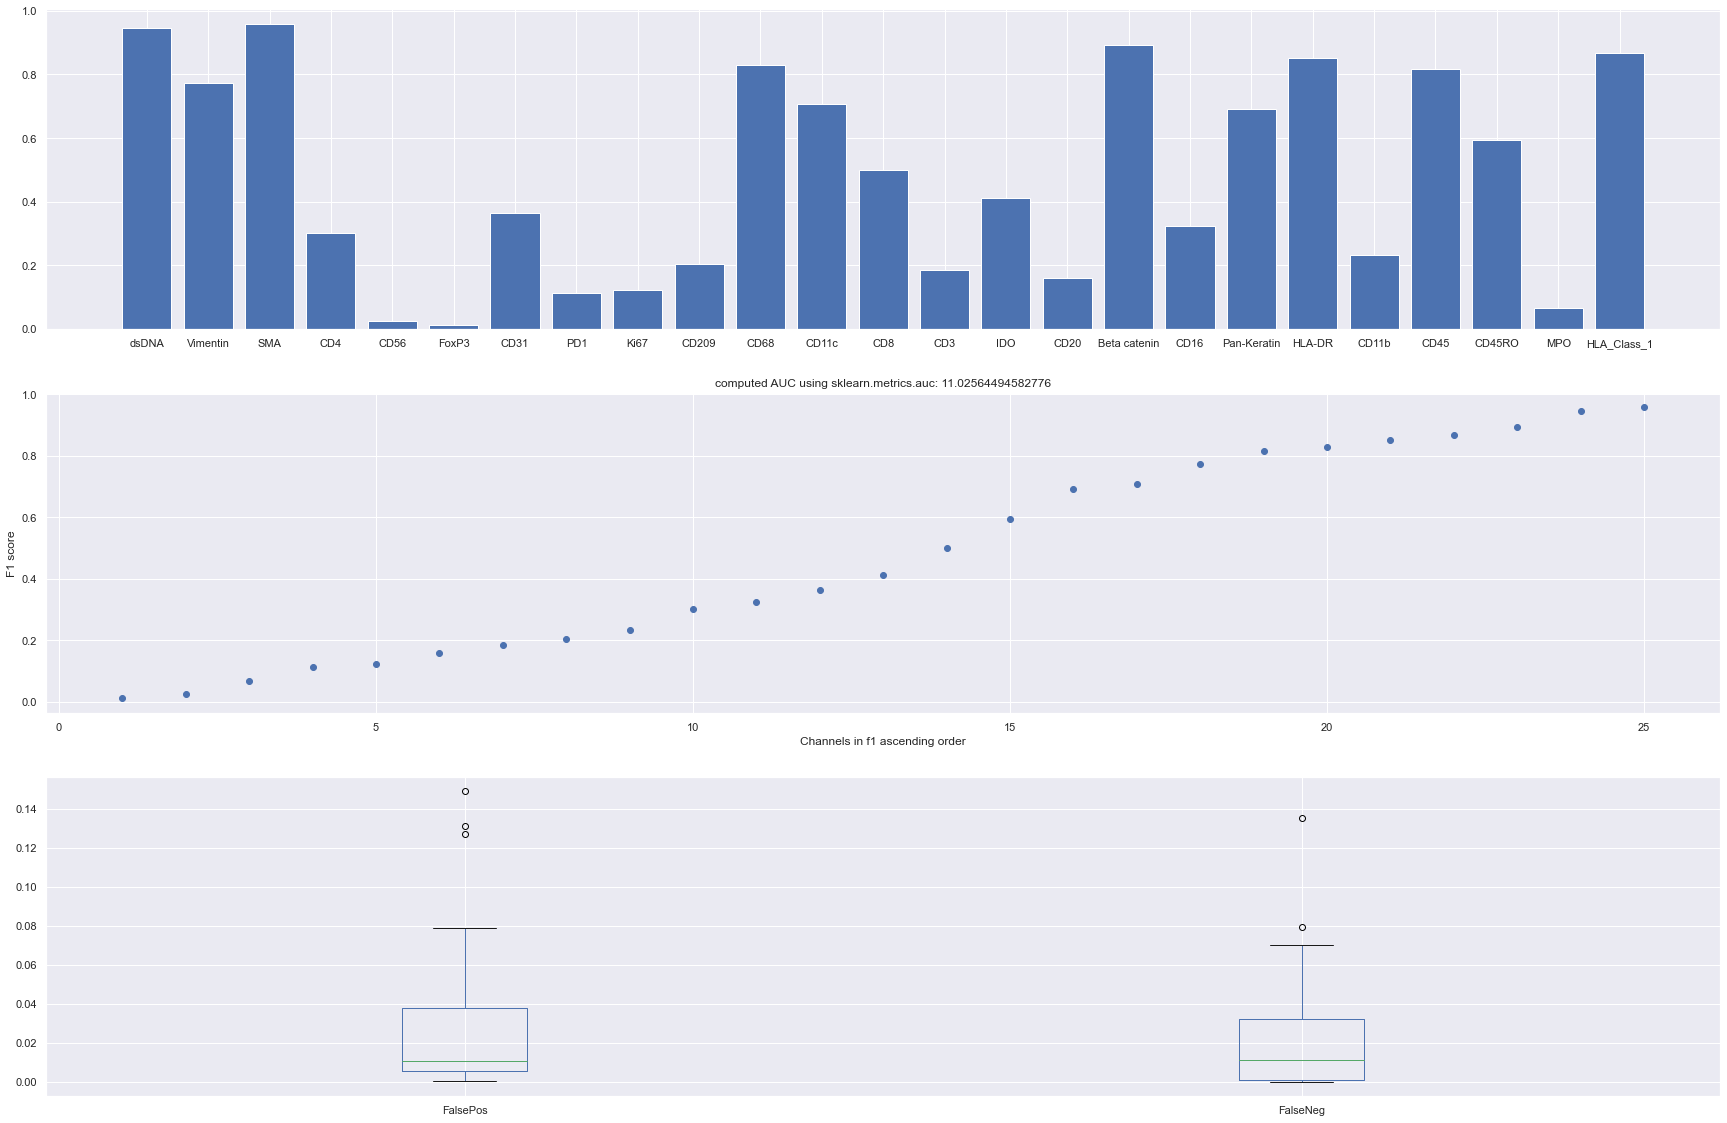

In [9]:
with open(r'Z:\vovam\Vova\data\matrices\8_25\channels.txt') as f:
    ch_list = f.read().split('\n')
scores, df = combine_everyting(all_data, hat_dat, ch_list, result_p)